<a href="https://colab.research.google.com/github/MichaelOforgu/Vehicle-Image-Classification-Using-Deep-Learning/blob/main/vehicle_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vehicle Image Classification Using Deep Learning

This project focuses on classifying images of cars and motorcycles using deep learning techniques. The model was trained to distinguish between these two vehicle types, leveraging TensorFlow, Keras, GPU acceleration, and OpenCV for image pre-processing.

# Install Dependencies and Setup

In [100]:
import tensorflow as tf
import os

In [101]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
os.chdir('/content/drive/MyDrive/DeepLearningProjects/VehicleClassification/')

In [103]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [104]:
tf.config.list_physical_devices('GPU')

[]

# Remove dodgy images

In [105]:
import cv2
import imghdr

In [106]:
data_dir = 'data'

In [107]:
image_exts = ['jpeg', 'jpg', 'bmp', 'png']

In [108]:
for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# Load Data

In [109]:
import numpy as np
from matplotlib import pyplot as plt

In [110]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 329 files belonging to 2 classes.


In [111]:
data_iterator = data.as_numpy_iterator()

In [112]:
batch = data_iterator.next()

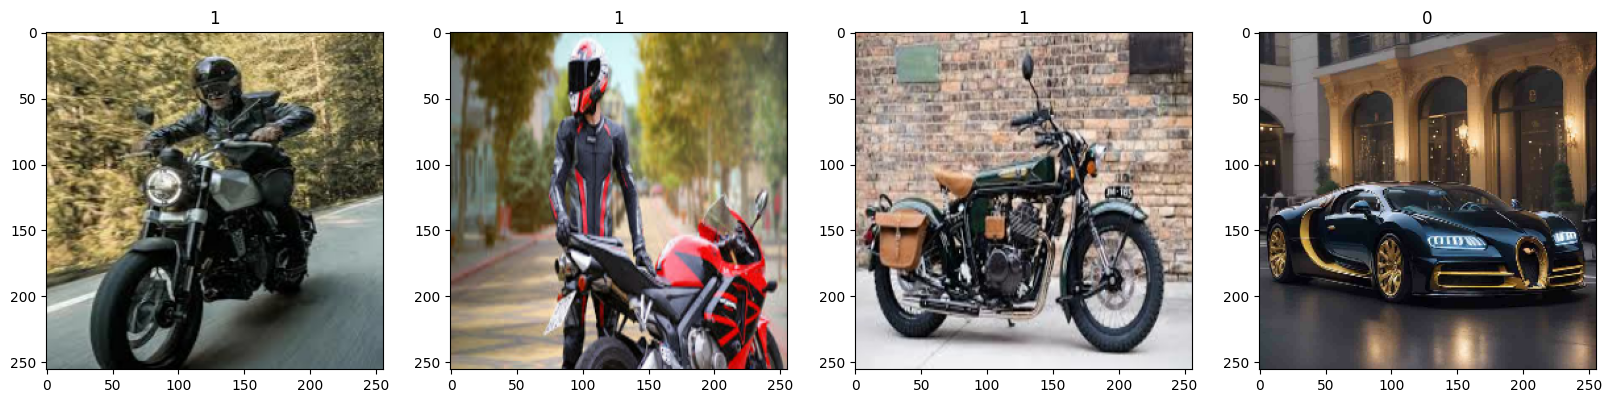

In [113]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

Class Labels:

Class 0 = Car: Images of cars are labeled as Class 0.

Class 1 = Motorcycle: Images of motorcycles are labeled as Class 1.

# Preprocessing

# Scale Data

In [114]:
data = data.map(lambda x, y: (x/255, y))

In [115]:
scaled_iterator = data.as_numpy_iterator()

In [116]:
batch = scaled_iterator.next()

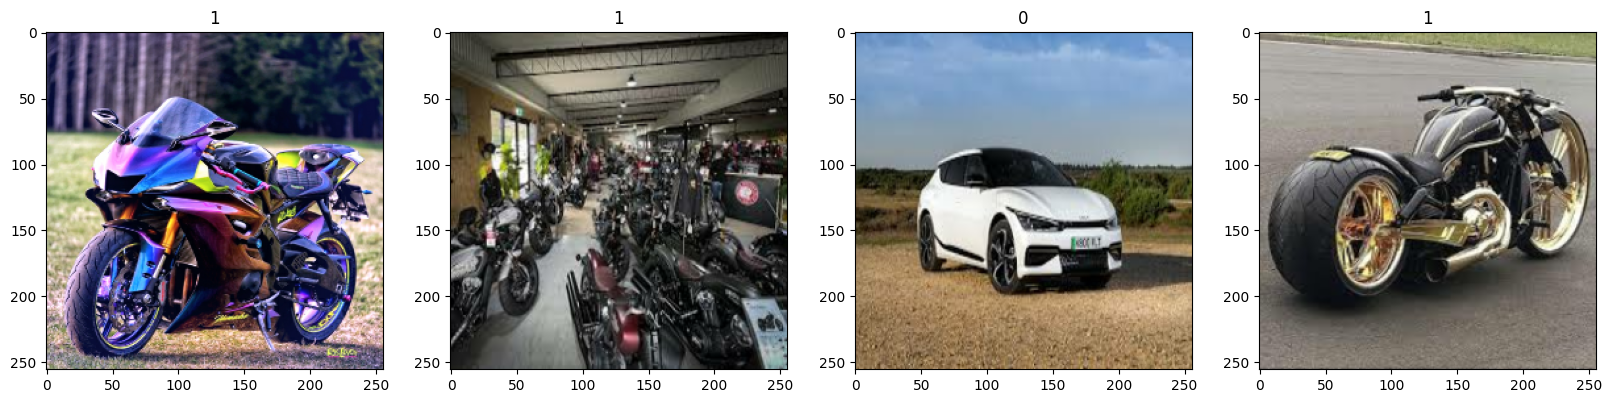

In [117]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

In [118]:
batch[0].max()

1.0

# Split Data

In [119]:
len(data)

11

In [120]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)+1
test_size = int(len(data)*.1)

In [121]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Building DL Model

In [122]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input

In [123]:
model = Sequential()

In [124]:
# Use Input layer for the input shape
model.add(Input(shape=(256, 256, 3)))

# Add convolutional layers
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Flatten and dense layers
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  # For binary classification (car vs motorcycle)

In [125]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [127]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 246016)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │      62,980,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,000,001 (240.33 MB)

 Trainable params: 63,000,001 (240.33 MB)

 Non-trainable params: 0 (0.00 B)

# Model Training

In [128]:
logdir='logs'

In [129]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [130]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.5229 - loss: 4.7203 - val_accuracy: 0.5625 - val_loss: 1.1145
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 40s 6s/step - accuracy: 0.5806 - loss: 0.8136 - val_accuracy: 0.5938 - val_loss: 0.6609
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 43s 6s/step - accuracy: 0.6090 - loss: 0.6521 - val_accuracy: 0.9062 - val_loss: 0.5288
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 6s/step - accuracy: 0.8651 - loss: 0.5007 - val_accuracy: 0.9479 - val_loss: 0.2052
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 6s/step - accuracy: 0.8381 - loss: 0.3733 - val_accuracy: 0.9896 - val_loss: 0.1670
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 42s 6s/step - accuracy: 0.9772 - loss: 0.1916 - val_accuracy: 0.9896 - val_loss: 0.1194
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.9845 - loss: 0.1121 - val_accuracy: 0.9792 - val_loss: 0.0487
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 77s 6s/step - accuracy: 0.9965 - loss: 0.0429 - val_accuracy: 0.9896 - val_loss: 0.0204
Epoch 9/

# Plot Model Performance

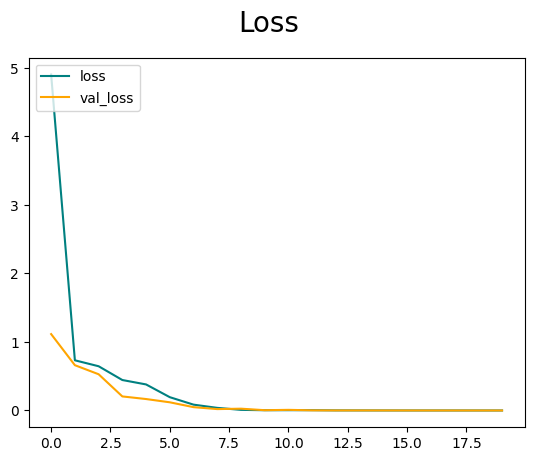

In [131]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

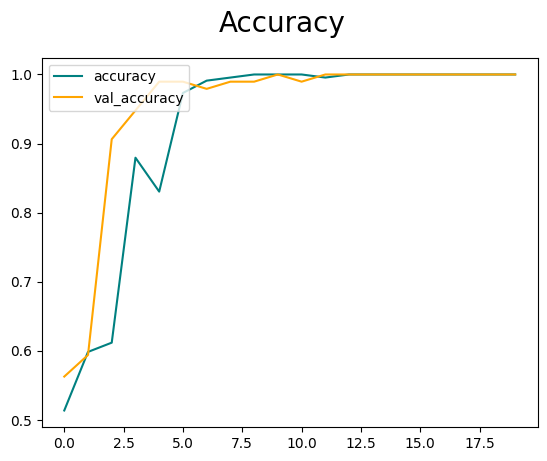

In [132]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Evaluate Model Performance

In [133]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [134]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [135]:
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step


In [136]:
print(f'Precision:{pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision:1.0, Recall:1.0, Accuracy:1.0


# Test Model

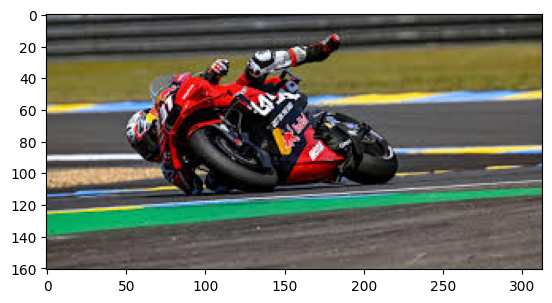

In [137]:
img = cv2.imread('test_images/motorcycle_test1.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

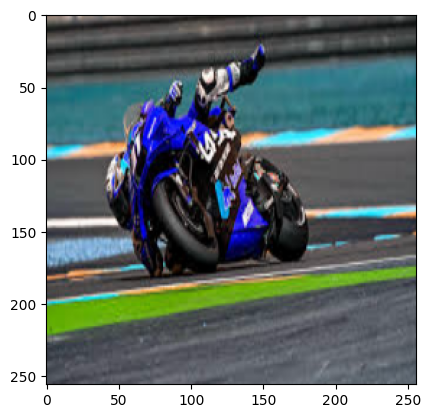

In [138]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [139]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [140]:
yhat

array([[0.9999951]], dtype=float32)

In [141]:
if yhat > 0.5:
    print(f'Predicted class is Motorcycle')
else:
    print(f'Predicted class is Car')

Predicted class is Motorcycle


# Save the Model

In [142]:
from tensorflow.keras.models import load_model

In [143]:
model.save(os.path.join('models','vehicleclassifier.keras'))

# Load Model

In [144]:
new_model = load_model(os.path.join('models','vehicleclassifier.keras'))

# Recompile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Make New Prediction

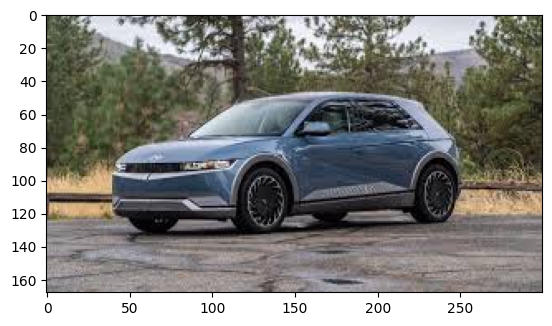

In [145]:
img = cv2.imread('test_images/car_test2.jpg')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

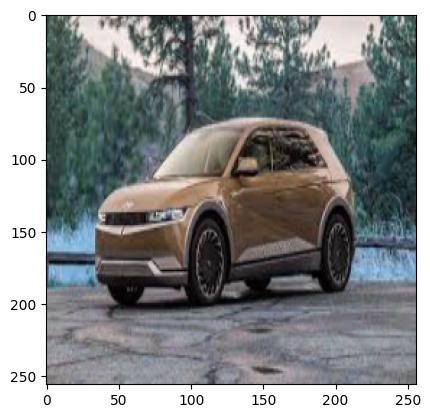

In [146]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [147]:
yhatnew = new_model.predict(np.expand_dims(resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step


In [148]:
if yhatnew > 0.5:
    print(f'Predicted class is Motorcycle')
else:
    print(f'Predicted class is Car')

Predicted class is Car
